## Import main libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio, display

## Engine

In [2]:
import os
import tqdm


class Engine(object):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.wavs_files = []
        self.extract_vocals()
        self.wavs_df = pd.DataFrame(self.wavs_files, columns=['filename'])
        self.wavs_df.set_index('filename', inplace=True)

    def __iterate_wavs(self):

        for root, _, files in os.walk(self.folder_path):
            for filename in files:
                if filename.endswith(".wav"):  # Check for WAV extension
                    yield os.path.join(filename)  # Yield full path

    def extract_vocals(self):
        for wav_file in (self.__iterate_wavs()):
            # print(f"Found WAV file: {wav_file}")
            self.wavs_files.append(wav_file)

    def classify_files(self):
        new_columns = {
            'speaker_id': np.empty(len(self.wavs_files), dtype=np.float_),
            'speaker_gender': np.empty(len(self.wavs_files), dtype=np.str_),
            'speaker_age': np.empty(len(self.wavs_files), dtype=np.float_),
            'spoken_word': np.empty(len(self.wavs_files), dtype=np.float_),
            'spoken_emotion': np.empty(len(self.wavs_files), dtype=np.float_),
            'record_id': np.empty(len(self.wavs_files), dtype=np.str_)
        }

        # Concatenate along columns (axis=1)
        self.wavs_df = pd.concat([self.wavs_df, pd.DataFrame(new_columns)],axis=1)
        self.wavs_df = self.wavs_df.iloc[:len(self.wavs_files)]

        for wav_file in self.wavs_files:
            wav_info = wav_file.split('-')
            # print(wav_info)
            self.wavs_df.loc[wav_file, :] = wav_info

        for idx, value in enumerate(self.wavs_df.loc[:, 'record_id']):
            self.wavs_df.iloc[idx, -1] = value.split('.')[0]






#### Instantiate engine

In [3]:
folder_path = "..//Basic-Arabic-Vocal-Emotions-Dataset//"
engine = Engine(folder_path)


In [4]:
engine.wavs_df.head()


""
filename
0-m-21-0-1-105.wav
0-m-21-0-2-106.wav
1-m-20-0-1-107.wav
10-f-20-0-1-0.wav
100-f-6-0-0-0.wav


In [5]:
engine.classify_files()

In [6]:
from scipy.fftpack import idct
import warnings

warnings.filterwarnings("ignore")


## Fonctions utiles
def Mel2Hz(mel): return 700 * (np.power(10, mel / 2595) - 1)


def Hz2Mel(freq): return 2595 * np.log10(1 + freq / 700)


def Hz2Ind(freq, fs, Tfft): return (freq * Tfft / fs).astype(int)


def hamming(T): return 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(T) / (T - 1))


#Réalisation d'un banc de filtres mel
def FiltresMel(fs, nf=36, Tfft=512, fmin=100, fmax=8000):
    Indices = Hz2Ind(Mel2Hz(np.linspace(Hz2Mel(fmin), Hz2Mel(min(fmax, fs / 2)), nf + 2)), fs, Tfft)
    filtres = np.zeros((int(Tfft / 2), nf))
    for i in range(nf): filtres[Indices[i]:Indices[i + 2], i] = hamming(Indices[i + 2] - Indices[i])
    return filtres


#Calcul du spectrogramme
def spectrogram(x, T, p, Tfft):
    S = []
    for i in range(0, len(x) - T, p): S.append(x[i:i + T] * hamming(T))  #windowing 
    S = np.fft.fft(S, Tfft)  #Fourier transform
    return np.abs(S), np.angle(S)  # amplitude and phase spectrum


#Calcul des mfcc
def mfcc(data, filtres, nc=13, T=256, p=64, Tfft=512):
    data = (data[1] - np.mean(data[1])) / np.std(data[1])  #normalize the data
    amp, ph = spectrogram(data, T, p, Tfft)
    amp_f = np.log10(np.dot(amp[:, :int(Tfft / 2)], filtres) + 1)
    return idct(amp_f, n=nc, norm='ortho')


In [7]:
fs = 8000  #la fréquence d'échantillonage des exemples
filtres = FiltresMel(fs)  #réalisation des filtres auditifs

In [8]:
words = ['like', 'didnt like', 'this', 'movie', 'super', 'correct', 'bad']  # pronounced words
nc = 100  # number of coefficients to extract with MFCC
filtered_audio = []
for index, row in engine.wavs_df.iterrows():
    filename = (folder_path + row[3] + '\\' + index)
    filtered_audio.append(mfcc(wavfile.read(filename), filtres, nc=nc))



### Encode gender 

In [9]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
engine.wavs_df['speaker_gender'] = encoder.fit_transform(engine.wavs_df['speaker_gender'])
engine.wavs_df.head()

,speaker_id,speaker_gender,speaker_age,spoken_word,spoken_emotion,record_id
0-m-21-0-1-105.wav,0,1,21,0,1,105
0-m-21-0-2-106.wav,0,1,21,0,2,106
1-m-20-0-1-107.wav,1,1,20,0,1,107
10-f-20-0-1-0.wav,10,0,20,0,1,0
100-f-6-0-0-0.wav,100,0,6,0,0,0


In [10]:
coded_df = pd.get_dummies(data=engine.wavs_df, columns=['speaker_gender', 'spoken_emotion','spoken_word'])
coded_df

,speaker_id,speaker_age,record_id,speaker_gender_0,speaker_gender_1,spoken_emotion_0,spoken_emotion_1,spoken_emotion_2,spoken_word_0,spoken_word_1,spoken_word_2,spoken_word_3,spoken_word_4,spoken_word_5,spoken_word_6
0-m-21-0-1-105.wav,0,21,105,0,1,0,1,0,1,0,0,0,0,0,0
0-m-21-0-2-106.wav,0,21,106,0,1,0,0,1,1,0,0,0,0,0,0
1-m-20-0-1-107.wav,1,20,107,0,1,0,1,0,1,0,0,0,0,0,0
10-f-20-0-1-0.wav,10,20,0,1,0,0,1,0,1,0,0,0,0,0,0
100-f-6-0-0-0.wav,100,6,0,1,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56-f-40-6-2-1695.wav,56,40,1695,1,0,0,0,1,0,0,0,0,0,0,1
6-m-21-6-0-1848.wav,6,21,1848,0,1,1,0,0,0,0,0,0,0,0,1
7-m-22-6-0-1849.wav,7,22,1849,0,1,1,0,0,0,0,0,0,0,0,1
8-m-18-6-2-1850.wav,8,18,1850,0,1,0,0,1,0,0,0,0,0,0,1


In [11]:
target = coded_df[['spoken_emotion_0','spoken_emotion_1','spoken_emotion_2']]

# Extract audio files and apply mfcc

# Get max shape 

In [12]:

def get_max_shape(array):
    max_shape = 0
    for value in array:
        if value.shape[0] > max_shape:
            max_shape = value.shape[0]
    return max_shape


max_shape = get_max_shape(filtered_audio)

# Zero padding (post_padding)

In [13]:
def post_padding(array, max_shape):
    new_array = (array)
    for idx, value in enumerate(array):
        shape0 = (value.shape)[0]
        pad0 = np.zeros((max_shape - shape0, nc))
        new_array[idx] = np.concatenate((value, pad0))

    return new_array


post_padding_audios = post_padding(filtered_audio, max_shape)

In [14]:
post_padding_audios = np.array(post_padding_audios)
post_padding_audios.shape  # 1935 files with 1276,nc shape

(1935, 1276, 100)

# Zero padding (pre_padding)

In [15]:
def pre_padding(array, max_shape):
    new_array = (array)
    for idx, value in enumerate(array):
        shape0 = (value.shape)[0]
        pad0 = np.zeros((max_shape - shape0, nc))
        new_array[idx] = np.concatenate((pad0, value))

    return new_array


pre_padding_audios = pre_padding(filtered_audio, max_shape)

In [16]:
pre_padding_audios = np.array(pre_padding_audios)
pre_padding_audios.shape  # 1935 files with 1276,nc shape

(1935, 1276, 100)

# Notice 
I noticed that there is **no difference** whether using **pre padding** or **post padding**

In [51]:
X = post_padding_audios
y = target
X.shape, y.shape


((1935, 1276, 100), (1935, 3))

In [212]:
from sklearn.preprocessing import StandardScaler

data = np.array(X)  # Replace with your actual data

# Reshape the data to 2D for standardization (samples, features)
reshaped_data = data.reshape(data.shape[0], -1)  # -1 flattens the remaining dimensions

scaler = StandardScaler()
scaler.fit(reshaped_data)

scaled_X = scaler.transform(reshaped_data)

# Reshape the scaled data back to the original 3D shape
scaled_X = scaled_X.reshape(data.shape)

In [213]:
scaled_X.shape

(1935, 1276, 100)

**I didn't notice an improvement using the scaled version so i didn't use it** 

# Data split

In [215]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)



# 1D Model
I prefered using Conv1D for MFCC data. Here's why:

* MFCC Shape: MFCC data, by its nature, represents features extracted over time. It typically has two dimensions:

    * Number of Mel-frequency cepstral coefficients (MFCCs): This captures the spectral content of the audio.
    * Time steps: This represents the sequence of these features over time.
* Conv1D for Sequences: Convolutional 1D layers are specifically designed to operate on **one-dimensional sequences like time series data**. They   learn filters that can identify patterns within these sequences.

* Conv2D for 2D Data: Convolutional 2D layers, on the other hand, are suited for **two-dimensional data like images**. They use filters that operate on a height and width dimension to extract features from spatial patterns.

In essence, MFCC data lacks a spatial dimension like an image. It only has features across time steps. Conv1D filters can effectively **slide along this time dimension**, capturing temporal features in the audio signal.

# Summary :
### Model Conv1D : 
#### Architecture :
Conv1D(32, (3)) -> MaxPool(2) -> Conv1D(64, (3)) -> MaxPool(2) -> Dropout(0.3) -> Conv1D(64, (3)) -> MaxPool(2) -> Dropout(0.3)  -> Flatten() -> FC(512) -> Dropout(0.6) -> FC(len(target))
#### Hyperparameters :
Optimizer : adam, lr : 0.001 (decay= 0.95), lossFunction : CategoricalCrossentropy(), batch_size=64, epochs=80

In [305]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=42)



In [306]:
# with tf.device('/cpu:0'):
#     X_train = tf.expand_dims(X_train, axis=-1)
#     X_test = tf.expand_dims(X_test, axis=-1)

In [307]:
X_train.shape

(1354, 1276, 100)

In [329]:
CNN_model1D = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, (3), activation='relu', input_shape=( X_train.shape[1],X_train.shape[2]),
                       kernel_regularizer=tf.keras.regularizers.L2(1e-6)),  # Input layer with channel dimension
    tf.keras.layers.MaxPooling1D((2)),
    tf.keras.layers.Conv1D(64, (3), activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-6)),  # Input layer with channel dimension
    tf.keras.layers.MaxPooling1D((2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(128, (3), activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-6)),  # Input layer with channel dimension
    tf.keras.layers.MaxPooling1D((2)),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Flatten(),  # Flatten before dense layers
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=target.shape[1], activation='softmax')
])

In [330]:
CNN_model1D.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adjust learning rate as needed
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

In [331]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.001)
def lr_schedule(epoch, lr):
  decay_rate = 0.9  # Learning rate decay rate
  return lr * decay_rate

learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)


In [376]:
with tf.device('/GPU:0'):
    CNN_model1D.fit(X_train, y_train, batch_size=32, epochs=30,callbacks=[learning_rate_scheduler], validation_data=(X_val, y_val))

Epoch 1/5
43/43 [==============================] - 1s 19ms/step - loss: 0.1000 - accuracy: 0.9749 - val_loss: 0.6749 - val_accuracy: 0.7586 - lr: 1.3303e-05
Epoch 2/5
43/43 [==============================] - 1s 12ms/step - loss: 0.0994 - accuracy: 0.9734 - val_loss: 0.6779 - val_accuracy: 0.7552 - lr: 1.1973e-05
Epoch 3/5
43/43 [==============================] - 1s 12ms/step - loss: 0.0990 - accuracy: 0.9764 - val_loss: 0.6792 - val_accuracy: 0.7621 - lr: 1.0775e-05
Epoch 4/5
43/43 [==============================] - 1s 12ms/step - loss: 0.0913 - accuracy: 0.9823 - val_loss: 0.6809 - val_accuracy: 0.7483 - lr: 9.6977e-06
Epoch 5/5
43/43 [==============================] - 1s 12ms/step - loss: 0.0996 - accuracy: 0.9727 - val_loss: 0.6824 - val_accuracy: 0.7552 - lr: 8.7280e-06


In [371]:
CNN_model1D.evaluate(X_test, y_test)
y_test.shape

10/10 [==============================] - 0s 32ms/step - loss: 0.7364 - accuracy: 0.7629


(291, 3)

In [361]:
# CNN_model1D.save('1DCnnModel--78.69%')  

78.69% : this was the best score i got with this architecture 

    tf.keras.layers.Conv1D(32, (3), activation='relu', input_shape=( X_train.shape[1],X_train.shape[2]),
                           kernel_regularizer=tf.keras.regularizers.L2(1e-6)),  # Input layer with channel dimension
    tf.keras.layers.MaxPooling1D((2)),
    tf.keras.layers.Conv1D(64, (3), activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-6)),  # Input layer with channel dimension
    tf.keras.layers.MaxPooling1D((2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(128, (3), activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-6)),  # Input layer with channel dimension
    tf.keras.layers.MaxPooling1D((2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),  # Flatten before dense layers
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=target.shape[1], activation='softmax')


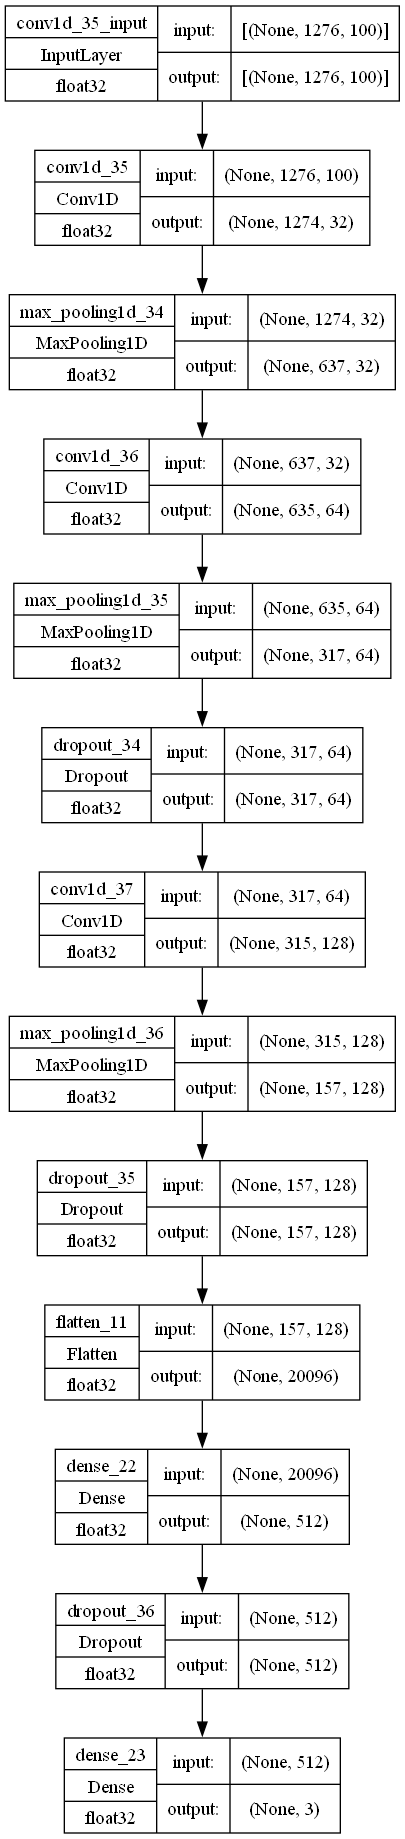

In [362]:
from tensorflow.keras.utils import plot_model

plot_model(CNN_model1D, show_shapes=True, show_layer_names=True, show_dtype=True)

# 2D Model

In [363]:
# X2_train, X2_holdout, y2_train, y2_holdout = train_test_split(X, y, test_size=0.2, random_state=42)
# X2_val, X2_test, y2_val, y2_test = train_test_split(X2_holdout, y2_holdout, test_size=0.4, random_state=42)


In [364]:
# with tf.device('/cpu:0'):
#     X2_train = tf.expand_dims(X2_train, axis=-1)
#     X2_test = tf.expand_dims(X2_test, axis=-1)


# Summary :
### Model Conv2D : 
#### Architecture :
Conv2D(32, (9, 9)) -> MaxPool(2,2) -> Conv2D(64, (7, 7)) -> MaxPool(2,2) -> Dropout(0.3) -> Conv2D(128, (5, 5)) -> MaxPool(2,2) -> Dropout(0.3) -> Flatten() -> FC(512) -> Dropout(0.6) -> FC(len(target))
#### Hyperparameters :
Optimizer : adam, lr : 0.001 (decay= 0.9), lossFunction : CategoricalCrossentropy(), batch_size=32, epochs=20

In [365]:
# CNN2D_model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (9, 9), activation='relu', input_shape=(max_shape, nc, 1),
#                            kernel_regularizer=tf.keras.regularizers.L2(1e-6)),  # Input layer with channel dimension
#     tf.keras.layers.MaxPooling2D((3, 3)),
# 
#     tf.keras.layers.Conv2D(64, (7, 7), activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-6)),  # Input layer with channel dimension
#     tf.keras.layers.MaxPooling2D((3, 3)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Conv2D(128, (5, 5), activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-6)),  # Input layer with channel dimension
#     tf.keras.layers.MaxPooling2D((3, 3)),
#     tf.keras.layers.Dropout(0.2),
# 
#     # Add more convolutional and pooling layers as needed
#     tf.keras.layers.Flatten(),  # Flatten before dense layers
#     # tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dense(512, activation='relu'),
#     # tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.6),
#     tf.keras.layers.Dense(units=target.shape[1], activation='softmax')
# ])
# 
# 


In [366]:
# CNN2D_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adjust learning rate as needed
#                   loss=tf.keras.losses.CategoricalCrossentropy(),
#                   metrics=['accuracy'])

* Dropout between conv2D and maxPooling didnt work well 
* Changing kernel size from 3,3 to (7,7) and (5,5) improved the model a lot

In [367]:
# with tf.device('/GPU:0'):
#     CNN2D_model.fit(X2_train, y2_train, batch_size=32, epochs=10,callbacks=[learning_rate_scheduler], validation_data=(X2_val, y2_val))

In [368]:
# CNN2D_model.evaluate(X2_test, y2_test)
# y_test.shape

In [369]:
# CNN2D_model.save('2DCnnModel--76%')

In [370]:
# from tensorflow.keras.utils import plot_model
# 
# plot_model(CNN2D_model, show_shapes=True, show_layer_names=True, show_dtype=True)